In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries
!pip install nibabel -t /home/aistudio/external-libraries

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 102kB 10.0MB/s a 0:00:011
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 3.3MB 15.7MB/s eta 0:00:01
     |████████████████████████████████| 15.7MB 48.6MB/s eta 0:00:01
     |████████████████████████████████| 40kB 35.2MB/s eta 0:00:01
     |████████████████████████████████| 71kB 40.5MB/s eta 0:00:01
ERROR: blackhole 1.0.1 has requirement numpy<=1.19.5, but you'll have numpy 1.21.4 which is incompatible.


In [1]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')
import numpy as np
import nibabel as nib
from util import * 
from tqdm import tqdm

In [ ]:
from util import *
volumes_path = './Pancreas-CT/data'
labels_path = './Pancreas-CT/TCIA_pancreas_labels-02-05-2017/'
preprocess_path = './work/data/preprocess/'

volumes = listdir(volumes_path)
labels = listdir(labels_path)

In [ ]:
labels[74]

'label0075.nii.gz'

In [2]:
!mkdir ./data/preprocess/
!mkdir ./data/preprocess/data/
!mkdir ./data/preprocess/label/

In [3]:
MIN_BOUND = -1024.
MAX_BOUND = 1024.
def norm_img(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image

In [4]:
import sys
if './external-libraries' not in sys.path:
    sys.path.append('./external-libraries')
import numpy as np
import nibabel as nib
from util import * 
from tqdm import tqdm
from PIL import Image
from paddle.vision.transforms import functional as F
volumes_path = './Pancreas-CT/data'
labels_path = './Pancreas-CT/TCIA_pancreas_labels-02-05-2017/'
data_preprocess_path = './data/preprocess/data/'
label_preprocess_path = './data/preprocess/label/'
volumes = listdir(volumes_path)
labels = listdir(labels_path)
assert len(volumes) == len(labels)  
count = 0
for i in tqdm(range(len(volumes))):
    count += 1
    if count != 75:continue

    print(os.path.join(volumes_path, volumes[i]))
    
    vol_file = nib.load(os.path.join(volumes_path, volumes[i]))
    lab_file = nib.load(os.path.join(labels_path, labels[i]))

    #读取CT数据
    volume = vol_file.get_fdata()
    label = lab_file.get_fdata()


    #去除噪声
    #分割胰腺参数为1，分割肿瘤参数为2
    volume = np.clip(volume,-1024,1024)
    
    #增强对比度
    #volume = volume.astype('uint8')
    #volume = F.adjust_contrast(volume, 1.1)
    label = clip_label(label, 1)
    volume = volume.astype(np.float16)
    label = label.astype(np.int64)
    volume = norm_img(volume)
    #取第slice_id片和之前之后的两片CT叠加到一起作为模型的输入,标签只去中间的一片
    for slice_id in range(1, volume.shape[2]-1):
        vol = volume[:,:,slice_id-1:slice_id+2]
        lab = np.fliplr(label[:,:,slice_id])
        if np.sum(lab) < 32:
            continue    
        #(512,512)->(512,512,1)
        lab = lab.reshape([lab.shape[0],lab.shape[1],1])
        #WHC -> CWH
        vol = np.swapaxes(vol,0,2)
        lab = np.swapaxes(lab,0,2)
        #数据来自LITS
        np.save(data_preprocess_path+"lits{}-{}.npy".format(volumes[i].rstrip(".nii").lstrip("volume"), slice_id),vol)
        np.save(label_preprocess_path+"lits{}-{}.npy".format(volumes[i].rstrip(".nii").lstrip("volume"), slice_id),lab)
        

  0%|          | 0/82 [00:00<?, ?it/s]

./Pancreas-CT/data/PANCREAS_0075.nii.gz


100%|██████████| 82/82 [00:10<00:00,  8.04it/s]


请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [23]:
import os
len(os.listdir('./data/preprocess/label/'))

79

In [7]:
import sys 
sys.path.append('/home/aistudio/external-libraries')
import paddle
from paddle.io import Dataset
import nibabel as nib
import os
from util import listdir
import util
from paddle.vision.transforms import Compose,Resize,CenterCrop,Normalize
from PIL import Image
from paddle.vision.transforms import functional as F
DATA_SIZE = 80
BATCH_SIZE = 1
data_path = 'data/preprocess/data'
label_path = 'data/preprocess/label'
IMAGE_SIZE = '512X512X*'
CLASS_NUM = 2

train_split_rate = 1

class MyDataset(Dataset):
    def __init__(self, num_samples, data_path,label_path, train_split_rate=0.9,mode = 'train'):
        super(MyDataset,self).__init__()
        self.num_samples = num_samples#返回数据集大小
        self.train_size = int(self.num_samples * train_split_rate)
        if mode == 'train': 
            self.data_paths = util.listdir(data_path)[:self.train_size]
            self.label_paths = util.listdir(label_path)[:self.train_size]
        else:
            self.data_paths = util.listdir(data_path)[self.train_size:]
            self.label_paths = util.listdir(label_path)[self.train_size:]
    def __getitem__(self, index):
        image = np.load(os.path.join(data_path,self.data_paths[index]),allow_pickle=True)
        mask = np.load(os.path.join(label_path,self.label_paths[index]),allow_pickle=True)
        #image = image.astype('uint8')
        
        #image = F.adjust_contrast(image, 1.5)

        return image, mask
    def __len__(self):
        return len(self.label_paths)
train_Dataset = MyDataset(DATA_SIZE, data_path, label_path,mode='train')
test_Dataset = MyDataset(DATA_SIZE, data_path, label_path,mode='test')
train_loader = paddle.io.DataLoader(train_Dataset, batch_size=BATCH_SIZE,shuffle=False)
test_loader = paddle.io.DataLoader(test_Dataset, batch_size=1,shuffle=False)


In [6]:
import sys 
sys.path.append('/home/aistudio/external-libraries')
import paddle
from paddle.io import Dataset
import nibabel as nib
import os
from util import listdir
import util
from paddle.vision.transforms import Compose,Resize,CenterCrop,Normalize
from PIL import Image
from paddle.vision.transforms import functional as F
DATA_SIZE = 7046
BATCH_SIZE = 5
data_path = 'data/preprocess/data'
label_path = 'data/preprocess/label'
IMAGE_SIZE = '512X512X*'
CLASS_NUM = 2

train_split_rate = 0.9

class MyDataset(Dataset):
    def __init__(self, num_samples, data_path,label_path, train_split_rate=0.9,mode = 'train'):
        super(MyDataset,self).__init__()
        self.num_samples = num_samples#返回数据集大小
        self.train_size = int(self.num_samples * train_split_rate)
        if mode == 'train': 
            self.data_paths = util.listdir(data_path)[:self.train_size]
            self.label_paths = util.listdir(label_path)[:self.train_size]
        else:
            self.data_paths = util.listdir(data_path)[self.train_size:]
            self.label_paths = util.listdir(label_path)[self.train_size:]
    def __getitem__(self, index):
        image = np.load(os.path.join(data_path,self.data_paths[index]),allow_pickle=True)
        mask = np.load(os.path.join(label_path,self.label_paths[index]),allow_pickle=True)
        #image = image.astype('uint8')
        
        #image = F.adjust_contrast(image, 1.5)

        return image, mask
    def __len__(self):
        return len(self.label_paths)
train_Dataset = MyDataset(DATA_SIZE, data_path, label_path,mode='train')
test_Dataset = MyDataset(DATA_SIZE, data_path, label_path,mode='test')
train_loader = paddle.io.DataLoader(train_Dataset, batch_size=BATCH_SIZE,shuffle=True)
test_loader = paddle.io.DataLoader(test_Dataset, batch_size=1,shuffle=False)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


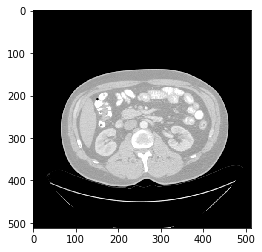

In [ ]:
for data1, label in test_loader:
    break
data = data1[0][0].numpy() * 255
data = data.astype('uint8')

data = F.adjust_contrast(data,2.2)
#data = data.astype('float32')
plt.imshow(data,cmap='gray')
plt.savefig('./contrast2.2_CT.png')

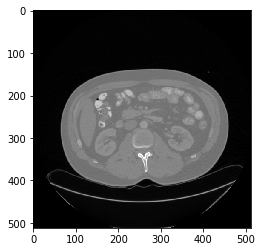

In [ ]:
import matplotlib.pyplot as plt
data = data1.astype('float32')
plt.imshow(data[0][1].numpy(),cmap='gray')
plt.savefig('./origin_CT.png')

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
data = data.astype('float32')

out = paddle.flatten(label[0][0], start_axis=0, stop_axis=1)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


NameError: name 'data' is not defined

(array([260328.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   1816.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

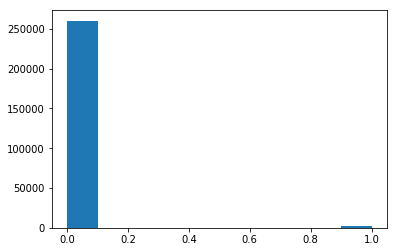

In [ ]:
import matplotlib.pyplot as plt 
plt.hist(out)

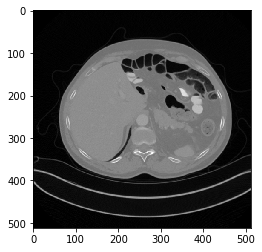

In [ ]:
plt.imshow(data[0][0].numpy(), cmap='gray')

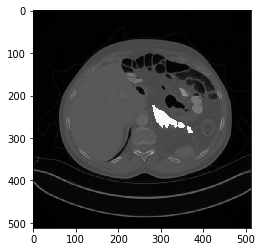

In [ ]:
plt.imshow(data[0][0].numpy()+label[0][0].numpy(), cmap='gray')

In [11]:
from paddle import fluid
import paddle.nn.functional as F
def create_loss(predict, label, num_classes=1):
    ''' 创建loss，结合dice和交叉熵 '''
    #predict:BATCH_SIZE,2,512,512
    predict = fluid.layers.transpose(predict, perm=[0, 2, 3, 1])#batch_size,512,512,2
    predict = fluid.layers.reshape(predict, shape=[-1, num_classes])
    predict = fluid.layers.softmax(predict)
    label = paddle.cast(label,'int64')
    label = fluid.layers.reshape(label, shape=[-1, 1])
    ce_loss = fluid.layers.cross_entropy(predict, label) # 计算交叉熵
    dice_loss = fluid.layers.dice_loss(predict,label)
    return fluid.layers.reduce_mean(ce_loss + dice_loss) # 最后使用的loss是dice和交叉熵的和，单独使用dice一般不是很稳定
    #return fluid.layers.reduce_mean(ce_loss)
def mean_iou(pred, label, num_classes=2):
    ''' 计算miou，评价网络分割结果的指标'''
    pred = fluid.layers.argmax(pred, axis=1)
    pred = fluid.layers.cast(pred, 'int32')
    label = fluid.layers.cast(label, 'int32')
    miou, wrong, correct = fluid.layers.mean_iou(pred, label, num_classes)
    return miou

def focal_loss(pred, label, num_classes=2):
    pred = fluid.layers.argmax(pred, axis=1)
    pred = fluid.layers.reshape(pred, shape=[BATCH_SIZE, -1, 512, 512])
    pred = fluid.layers.cast(pred, 'float32')
    lable = fluid.layers.cast(label, 'float32')
    return F.sigmoid_focal_loss(pred, label, reduction='mean',alpha=0.75)


def hybird_loss(predict, label):
    focal_loss1 = focal_loss(predict, label, num_classes=2)
    ori_loss = create_loss(predict, label, num_classes=2)
    return focal_loss1 + ori_loss

def Gernel_dice_loss(pre,loss, num_classes=2):
    return 


def deep_super_Fusion_loss(out, label, num_classes=2):
    loss = 0
    loss += focal_loss(out[0], label, num_classes=2)
    loss += focal_loss(out[1], label, num_classes=2)
    loss += focal_loss(out[2], label, num_classes=2)
    loss += focal_loss(out[3], label, num_classes=2)
    loss += focal_loss(out[4], label, num_classes=2)
    return loss
    
def dice_mertic(predict,label,num_classes=2):
    predict = fluid.layers.transpose(predict,perm=[0,2,3,1])
    predict = fluid.layers.reshape(predict,shape=[-1,num_classes])
    predict = fluid.layers.softmax(predict)
    label = paddle.cast(label,'int64')
    label = fluid.layers.reshape(label,shape=[-1,1])
    dice_loss = fluid.layers.dice_loss(predict,label)
    return 1-dice_loss


In [9]:
import paddle
import paddle.fluid as fluid
from paddle.fluid.optimizer import AdamOptimizer
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, Conv2DTranspose
from paddle.fluid.dygraph.base import to_variable
import paddle.nn as nn
import numpy as np
from paddle import fluid
import paddle.nn.functional as F
class ASPPPooling(nn.Layer):
    def __init__(self,num_channels,num_filters):
        super(ASPPPooling,self).__init__()
        self.adaptive_pool = nn.AdaptiveMaxPool2D(output_size=3)
        self.features = nn.Sequential(
                                        nn.Conv2D(num_channels, num_filters,1),
                                        nn.BatchNorm(num_filters, act="relu")
                                    )
    def forward(self, inputs):
        n1, c1, h1, w1 = inputs.shape
        x = self.adaptive_pool(inputs)
        x = self.features(x)
        x = nn.functional.interpolate(x, (h1, w1), align_corners=False)
        return x
class ASPPConv(nn.Layer):
    def __init__(self,num_channels,num_filters,dilations):
        super(ASPPConv,self).__init__()
        self.asppconv = nn.Sequential(
                            nn.Conv2D(num_channels,num_filters,3,padding=dilations,dilation=dilations),
                            nn.BatchNorm(num_filters, act="relu")
                            )
    def forward(self,inputs):
        x = self.asppconv(inputs)
        return x

#ASPP模块最大的特点是使用了空洞卷积来增大感受野
class ASPPModule(nn.Layer):
    def __init__(self, num_channels, num_filters, rates):
        super(ASPPModule, self).__init__()
        self.features = nn.LayerList()
        #Layer1:1x1卷积
        self.features.append(nn.Sequential(
                                        nn.Conv2D(num_channels, num_filters,1),
                                        nn.BatchNorm(num_filters, act="relu")
                                          )
                            )
        #Layer2:三个空洞卷积模块
        for r in rates:
            self.features.append(ASPPConv(num_channels, num_filters, r))
        #Layer3:适应输出尺寸的池化
        self.features.append(ASPPPooling(num_channels, num_filters))
        #Layer4:将前几层layer concat之后的统一操作
        self.project  = nn.Sequential(
                                    nn.Conv2D(num_filters*(2+len(rates)), num_filters, 1),#TODO
                                    nn.BatchNorm(num_filters, act="relu")
                                     )
    def forward(self, inputs):
        out = []
        for op in self.features:
            out.append(op(inputs))
        x = paddle.concat(x=out,axis=1)
        x = self.project(x)
        return x
#Upgraded ASPP Module作为DeepLabv3的head
class DeeplabHead(nn.Layer):
    def __init__(self, num_channels):
        super(DeeplabHead, self).__init__()
        self.head = nn.Sequential(
                            ASPPModule(num_channels, 256, [2, 4, 6]),
                            nn.Conv2D(256, 512, 3, padding=1),
                            nn.BatchNorm(512, act="relu"),
                            nn.Conv2D(512, num_channels, 1)        
                            )
    def forward(self, inputs):
        x = self.head(inputs)
        return x

class Separable_base_conv(nn.Layer):
    def __init__(self, input_channels, num_filters):
        super(Separable_base_conv,self).__init__()
        self.pointwise_conv = nn.Conv2D(in_channels=input_channels, out_channels=num_filters, kernel_size=1,stride=1)
        self.depthwise_conv = nn.Conv2D(in_channels=num_filters, out_channels=num_filters, kernel_size=3,stride=1, groups=num_filters,padding=1)
    def forward(self, inputs):
        x = self.pointwise_conv(inputs)
        #print(x.shape)
        x = self.depthwise_conv(x)
        #print(x.shape)
        return x

class DoubleSepConv(nn.Layer):
    def __init__(self, in_channel, out_channel):
        super(DoubleSepConv, self).__init__()
        self.layers = nn.Sequential(
            Separable_base_conv(in_channel, out_channel),
            nn.BatchNorm(out_channel,act='relu'),
            nn.Conv2D(out_channel, out_channel, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm(out_channel,act='relu')
        )
    def forward(self,inputs):
        x = self.layers(inputs)
        return x

class DoubleConv(fluid.dygraph.Layer):
    def __init__(self, inchannel, outchannel):
        super(DoubleConv, self).__init__()
        self.layers = fluid.dygraph.Sequential(
            Conv2D(inchannel, outchannel, filter_size=3,stride=1, padding=1),
            fluid.BatchNorm(outchannel,act='relu'),
            Conv2D(outchannel, outchannel, filter_size=3, stride=1,padding=1),
            fluid.BatchNorm(outchannel, act='relu'),
        )

    def forward(self, x):
        x = self.layers(x)
        return x




class Unet2(fluid.dygraph.Layer):
    def __init__(self, input, out):
        super(Unet2, self).__init__()

        self.c1 = DoubleConv(input, 64)
        self.maxpool1 = Pool2D(pool_size=2,pool_type='max',pool_stride=2,)
        self.c2 = DoubleSepConv(64, 128)
        self.maxpool2 = Pool2D(pool_size=2,pool_type='max',pool_stride=2,)
        self.c3 = DoubleSepConv(128, 256)
        self.maxpool3 = Pool2D(pool_size=2,pool_type='max',pool_stride=2,)
        self.c4 = DoubleSepConv(256, 512)
        self.maxpool4 = Pool2D(pool_size=2,pool_type='max',pool_stride=2,)
        self.c5 = DoubleSepConv(512, 1024)

        feature_dim = 1024      #输出层通道1024
        self.deeplabhead = DeeplabHead(feature_dim)

        self.up6 = Conv2DTranspose(1024, 512, 2, stride=2)
        self.c6 = DoubleSepConv(1024, 512)
        self.up7 = Conv2DTranspose(512, 256, 2, stride=2)
        self.c7 = DoubleSepConv(512, 256)
        self.up8 = Conv2DTranspose(256, 128, 2, stride=2)
        self.c8 = DoubleSepConv(256, 128)
        self.up9 = Conv2DTranspose(128, 64, 2, stride=2)
        self.c9 = DoubleSepConv( 128, 64)

        self.c10 = Conv2D(64, out, 1)
        
        self.short1 = nn.Conv2D(64,128,kernel_size=1,stride=2,padding=0)
        self.short2 = nn.Conv2D(128, 256, kernel_size=1,stride=2,padding=0)
        self.short3 = nn.Conv2D(256, 512, kernel_size=1, stride=2, padding=0)
        self.short4 = nn.Conv2D(512, 1024, kernel_size=1, stride=2, padding=0)


    def forward(self, inputs):
        c1 = self.c1(inputs)
        p1 = self.maxpool1(c1)
        c2 = self.c2(p1)
        p2 = self.maxpool2(c2)

        c3 = self.c3(p2)
        p4 = self.maxpool3(c3)        

        c4 = self.c4(p4)
        p5 = self.maxpool4(c4)
        c5 = self.c5(p5)
        
        c5 = self.deeplabhead(c5)


        up6 = self.up6(c5)
        merge6 = fluid.layers.concat([up6, c4], axis=1)
        c6 = self.c6(merge6)
        up7 = self.up7(c6)
        merge7 = fluid.layers.concat([up7, c3], axis=1)
        c7= self.c7(merge7)
        up8 = self.up8(c7)
        merge8 = fluid.layers.concat([up8, c2], axis=1)
        c8 = self.c8(merge8)
        up9 = self.up9(c8)
        merge9 = fluid.layers.concat([up9 , c1], axis=1)
        c9 = self.c9(merge9)

        c10 = self.c10(c9)
        out = fluid.layers.logsigmoid(c10)
        return out        

paddle.summary(Unet2(3,2), (1, 3, 512, 512))

W1129 17:13:06.837234   474 device_context.cc:404] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W1129 17:13:06.874670   474 device_context.cc:422] device: 0, cuDNN Version: 7.6.


---------------------------------------------------------------------------------
    Layer (type)          Input Shape          Output Shape         Param #    
      Conv2D-1         [[1, 3, 512, 512]]   [1, 64, 512, 512]        1,792     
     BatchNorm-1      [[1, 64, 512, 512]]   [1, 64, 512, 512]         256      
      Conv2D-2        [[1, 64, 512, 512]]   [1, 64, 512, 512]       36,928     
     BatchNorm-2      [[1, 64, 512, 512]]   [1, 64, 512, 512]         256      
    DoubleConv-1       [[1, 3, 512, 512]]   [1, 64, 512, 512]          0       
      Pool2D-1        [[1, 64, 512, 512]]   [1, 64, 256, 256]          0       
      Conv2D-3        [[1, 64, 256, 256]]   [1, 128, 256, 256]       8,320     
      Conv2D-4        [[1, 128, 256, 256]]  [1, 128, 256, 256]       1,280     
Separable_base_conv-1 [[1, 64, 256, 256]]   [1, 128, 256, 256]         0       
     BatchNorm-3      [[1, 128, 256, 256]]  [1, 128, 256, 256]        512      
      Conv2D-5        [[1, 128, 256, 2

{'total_params': 29588098, 'trainable_params': 29556354}

In [ ]:
import paddle
import paddle.fluid as fluid
from paddle.fluid.optimizer import AdamOptimizer
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, Conv2DTranspose
from paddle.fluid.dygraph.base import to_variable
import paddle.nn as nn
import numpy as np
from paddle import fluid
import paddle.nn.functional as F
class ASPPPooling(nn.Layer):
    def __init__(self,num_channels,num_filters):
        super(ASPPPooling,self).__init__()
        self.adaptive_pool = nn.AdaptiveMaxPool2D(output_size=3)
        self.features = nn.Sequential(
                                        nn.Conv2D(num_channels, num_filters,1),
                                        nn.BatchNorm(num_filters, act="relu")
                                    )
    def forward(self, inputs):
        n1, c1, h1, w1 = inputs.shape
        x = self.adaptive_pool(inputs)
        x = self.features(x)
        x = nn.functional.interpolate(x, (h1, w1), align_corners=False)
        return x
class ASPPConv(nn.Layer):
    def __init__(self,num_channels,num_filters,dilations):
        super(ASPPConv,self).__init__()
        self.asppconv = nn.Sequential(
                            nn.Conv2D(num_channels,num_filters,3,padding=dilations,dilation=dilations),
                            nn.BatchNorm(num_filters, act="relu")
                            )
    def forward(self,inputs):
        x = self.asppconv(inputs)
        return x

#ASPP模块最大的特点是使用了空洞卷积来增大感受野
class ASPPModule(nn.Layer):
    def __init__(self, num_channels, num_filters, rates):
        super(ASPPModule, self).__init__()
        self.features = nn.LayerList()
        #Layer1:1x1卷积
        self.features.append(nn.Sequential(
                                        nn.Conv2D(num_channels, num_filters,1),
                                        nn.BatchNorm(num_filters, act="relu")
                                          )
                            )
        #Layer2:三个空洞卷积模块
        for r in rates:
            self.features.append(ASPPConv(num_channels, num_filters, r))
        #Layer3:适应输出尺寸的池化
        self.features.append(ASPPPooling(num_channels, num_filters))
        #Layer4:将前几层layer concat之后的统一操作
        self.project  = nn.Sequential(
                                    nn.Conv2D(num_filters*(2+len(rates)), num_filters, 1),#TODO
                                    nn.BatchNorm(num_filters, act="relu")
                                     )
    def forward(self, inputs):
        out = []
        for op in self.features:
            out.append(op(inputs))
        x = paddle.concat(x=out,axis=1)
        x = self.project(x)
        return x
#Upgraded ASPP Module作为DeepLabv3的head
class DeeplabHead(nn.Layer):
    def __init__(self, num_channels):
        super(DeeplabHead, self).__init__()
        self.head = nn.Sequential(
                            ASPPModule(num_channels, 256, [2, 4, 6]),
                            nn.Conv2D(256, 512, 3, padding=1),
                            nn.BatchNorm(512, act="relu"),
                            nn.Conv2D(512, num_channels, 1)        
                            )
    def forward(self, inputs):
        x = self.head(inputs)
        return x

class Separable_base_conv(nn.Layer):
    def __init__(self, input_channels, num_filters):
        super(Separable_base_conv,self).__init__()
        self.pointwise_conv = nn.Conv2D(in_channels=input_channels, out_channels=num_filters, kernel_size=1,stride=1)
        self.depthwise_conv = nn.Conv2D(in_channels=num_filters, out_channels=num_filters, kernel_size=3,stride=1, groups=num_filters,padding=1)
    def forward(self, inputs):
        x = self.pointwise_conv(inputs)
        #print(x.shape)
        x = self.depthwise_conv(x)
        #print(x.shape)
        return x

class DoubleSepConv(nn.Layer):
    def __init__(self, in_channel, out_channel):
        super(DoubleSepConv, self).__init__()
        self.layers = nn.Sequential(
            Separable_base_conv(in_channel, out_channel),
            nn.BatchNorm(out_channel,act='relu'),
            nn.Conv2D(out_channel, out_channel, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm(out_channel,act='relu')
        )
    def forward(self,inputs):
        x = self.layers(inputs)
        return x

class DoubleConv(fluid.dygraph.Layer):
    def __init__(self, inchannel, outchannel):
        super(DoubleConv, self).__init__()
        self.layers = fluid.dygraph.Sequential(
            Conv2D(inchannel, outchannel, filter_size=3,stride=1, padding=1),
            fluid.BatchNorm(outchannel,act='relu'),
            Conv2D(outchannel, outchannel, filter_size=3, stride=1,padding=1),
            fluid.BatchNorm(outchannel, act='relu'),
        )

    def forward(self, x):
        x = self.layers(x)
        return x



#增加残差块
class Unet2(fluid.dygraph.Layer):
    def __init__(self, input, out):
        super(Unet2, self).__init__()

        self.c1 = DoubleConv(input, 64)
        self.maxpool1 = Pool2D(pool_size=2,pool_type='max',pool_stride=2,)
        self.c2 = DoubleSepConv(64, 128)
        self.maxpool2 = Pool2D(pool_size=2,pool_type='max',pool_stride=2,)
        self.c3 = DoubleSepConv(128, 256)
        self.maxpool3 = Pool2D(pool_size=2,pool_type='max',pool_stride=2,)
        self.c4 = DoubleSepConv(256, 512)
        self.maxpool4 = Pool2D(pool_size=2,pool_type='max',pool_stride=2,)
        self.c5 = DoubleSepConv(512, 1024)

        feature_dim = 1024      #输出层通道1024
        self.deeplabhead = DeeplabHead(feature_dim)

        self.up6 = Conv2DTranspose(1024, 512, 2, stride=2)
        self.c6 = DoubleSepConv(1024, 512)
        self.up7 = Conv2DTranspose(512, 256, 2, stride=2)
        self.c7 = DoubleSepConv(512, 256)
        self.up8 = Conv2DTranspose(256, 128, 2, stride=2)
        self.c8 = DoubleSepConv(256, 128)
        self.up9 = Conv2DTranspose(128, 64, 2, stride=2)
        self.c9 = DoubleSepConv(128, 64)

        self.c10 = Conv2D(64, out, 1)
        
        self.short1 = nn.Conv2D(64,128,kernel_size=1,stride=2,padding=0)
        self.short2 = nn.Conv2D(128, 256, kernel_size=1,stride=2,padding=0)
        self.short3 = nn.Conv2D(256, 512, kernel_size=1, stride=2, padding=0)
        self.short4 = nn.Conv2D(512, 1024, kernel_size=1, stride=2, padding=0)

#s2没有参与相加，我们认为在浅层的特征提取并没有损失太多的细节特征
    def forward(self, inputs):
        c1 = self.c1(inputs)
        p1 = self.maxpool1(c1)
        
        s1 = self.short1(p1)
        
        c2 = self.c2(p1)
        p2 = self.maxpool2(c2)
        

        #merge2 = fluid.layers.concat([s1, p2], axis=1)
        sum2 = paddle.add(s1, p2)
        s2 = self.short2(sum2)
        

        c3 = self.c3(p2)
        p4 = self.maxpool3(c3)        

        #merge3 = fluid.layers.concat([s2, p4],axis=1)
        sum3 = paddle.add(s2, p4)
        s3 = self.short3(sum3)

        c4 = self.c4(sum3)
        p5 = self.maxpool4(c4)
        
        #merge4 = fluid.layers.concat([s3, p5], axis=1)
        sum4 = paddle.add(s3, p5)
        
        c5 = self.c5(sum4)
        
        c5 = self.deeplabhead(c5)
        up6 = self.up6(c5)
        merge6 = fluid.layers.concat([up6, c4], axis=1)
        c6 = self.c6(merge6)
        up7 = self.up7(c6)
        merge7 = fluid.layers.concat([up7, c3], axis=1)
        c7= self.c7(merge7)
        up8 = self.up8(c7)
        merge8 = fluid.layers.concat([up8, c2], axis=1)
        c8 = self.c8(merge8)
        up9 = self.up9(c8)
        merge9 = fluid.layers.concat([up9 , c1], axis=1)
        c9 = self.c9(merge9)

        c10 = self.c10(c9)
        out = fluid.layers.logsigmoid(c10)
        return out        

paddle.summary(Unet2(3,2), (1, 3, 512, 512))

----------------------------------------------------------------------------------
     Layer (type)          Input Shape          Output Shape         Param #    
      Conv2D-118        [[1, 3, 512, 512]]   [1, 64, 512, 512]        1,792     
     BatchNorm-76      [[1, 64, 512, 512]]   [1, 64, 512, 512]         256      
      Conv2D-119       [[1, 64, 512, 512]]   [1, 64, 512, 512]       36,928     
     BatchNorm-77      [[1, 64, 512, 512]]   [1, 64, 512, 512]         256      
     DoubleConv-4       [[1, 3, 512, 512]]   [1, 64, 512, 512]          0       
      Pool2D-13        [[1, 64, 512, 512]]   [1, 64, 256, 256]          0       
      Conv2D-153       [[1, 64, 256, 256]]   [1, 128, 128, 128]       8,320     
      Conv2D-120       [[1, 64, 256, 256]]   [1, 128, 256, 256]       8,320     
      Conv2D-121       [[1, 128, 256, 256]]  [1, 128, 256, 256]       1,280     
Separable_base_conv-25 [[1, 64, 256, 256]]   [1, 128, 256, 256]         0       
     BatchNorm-78      [[1

{'total_params': 29761026, 'trainable_params': 29729282}

In [ ]:
#from Unet import Unet
#from ResSepUnet import Unet2 
#from SubUnet import SubUnet
EPOCH = 30
input_channels = 3
out_filiters = 2

net = Unet2(3,2)
#net = Unet2(3,2)
#net = Unet(input_channels, out_filiters)
#net = Deeplabv3()#deepUnet training
#net = XceptUnet(input_channels, out_filiters)
optim_RMS = paddle.optimizer.RMSProp(learning_rate=0.0005, 
                                 rho=0.9, 
                                 momentum=0.3, 
                                 epsilon=1e-07, 
                                 centered=False,
                                 parameters=net.parameters())
optim_Adam = paddle.optimizer.Adam(learning_rate=0.0005,
                                   parameters=net.parameters(),
                                   )
loss_list_RMS = []
for e in range(EPOCH):
    for i, (image,label) in enumerate(train_loader):
        image = image.astype('float32')
        out = net(image)
        #print(out.shape)
        label = paddle.cast(label, 'float32')
        #label = my_encoder(label)
        loss = create_loss(out, label, num_classes=2)
        #loss = focal_loss(out, label, num_classes=2)
        #loss = hybird_loss(out,label)
        #loss = Ms_ssim_loss(out, label)
        #loss = deep_super_Fusion_loss(out, label, num_classes=2)
        if i % 500 == 0:
            mIOU = mean_iou(out,label,num_classes=2)
            print("Epoch {} batch {}: mIOU:{}".format(e, i, mIOU))
        

        ####################################
        #loss_list_RMS.append(loss)

        ####################################
        avg_loss = paddle.mean(loss)
        avg_loss.backward()
        optim_RMS.minimize(avg_loss)
        net.clear_gradients()
        if i % 100 == 0:
            print("Epoch {} batch {}: loss = {}".format(e, i, np.mean(loss.numpy())))
            #loss_list.append(np.mean(loss.numpy()))
    if e % 2 == 0:
        paddle.save(net.state_dict(),'Res+Sep+ASPP_epoch{}.pdparams'.format(e))

Epoch 0 batch 0: mIOU:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [0.27028304])
Epoch 0 batch 0: loss = 1.128629446029663
Epoch 0 batch 100: loss = 0.09507661312818527
Epoch 0 batch 200: loss = 0.04069297015666962
Epoch 0 batch 300: loss = 0.01840072125196457
Epoch 0 batch 400: loss = 0.01321906503289938
Epoch 0 batch 500: mIOU:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [0.76702100])
Epoch 0 batch 500: loss = 0.007202749140560627
Epoch 0 batch 600: loss = 0.007771330885589123
Epoch 0 batch 700: loss = 0.006589125841856003
Epoch 0 batch 800: loss = 0.006664220709353685
Epoch 0 batch 900: loss = 0.009692568331956863
Epoch 0 batch 1000: mIOU:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [0.83752531])
Epoch 0 batch 1000: loss = 0.005837009288370609
Epoch 0 batch 1100: loss = 0.00684672174975276
Epoch 0 batch 1200: loss = 0.007447613403201103
Epoch 1 batch 0: mIOU:Tensor(shape=[1], dty

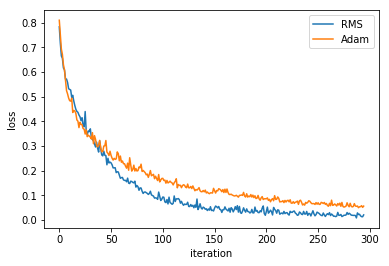

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_list_RMS[5:300])
plt.plot(loss_list_Adam[5:300],)
plt.xlabel("iteration")
plt.ylabel('loss')
plt.legend(['RMS','Adam'])
#plt.show()
plt.savefig('./loss_campare2.png')

In [ ]:
from paddle.nn import functional as F
def dice_mertic(predict,label,num_classes=2):
    predict = fluid.layers.transpose(predict,perm=[0,2,3,1])
    label = fluid.layers.transpose(label, perm=[0,2,3,1])
    #predict = fluid.layers.reshape(predict,shape=[-1,num_classes])
    #predict = fluid.layers.softmax(predict)
    label = paddle.cast(label,'int64')
    #label = fluid.layers.reshape(label,shape=[-1,1])
    dice_loss = F.dice_loss(predict,label).numpy()
    return 1-dice_loss

In [ ]:
net

Unet2(
  (c1): DoubleConv(
    (layers): Sequential(
      (0): Conv2D()
      (1): BatchNorm()
      (2): Conv2D()
      (3): BatchNorm()
    )
  )
  (maxpool1): Pool2D()
  (c2): DoubleSepConv(
    (layers): Sequential(
      (0): Separable_base_conv(
        (pointwise_conv): Conv2D(64, 128, kernel_size=[1, 1], data_format=NCHW)
        (depthwise_conv): Conv2D(128, 128, kernel_size=[3, 3], padding=1, groups=128, data_format=NCHW)
      )
      (1): BatchNorm()
      (2): Conv2D(128, 128, kernel_size=[3, 3], padding=1, data_format=NCHW)
      (3): BatchNorm()
    )
  )
  (maxpool2): Pool2D()
  (c3): DoubleSepConv(
    (layers): Sequential(
      (0): Separable_base_conv(
        (pointwise_conv): Conv2D(128, 256, kernel_size=[1, 1], data_format=NCHW)
        (depthwise_conv): Conv2D(256, 256, kernel_size=[3, 3], padding=1, groups=256, data_format=NCHW)
      )
      (1): BatchNorm()
      (2): Conv2D(256, 256, kernel_size=[3, 3], padding=1, data_format=NCHW)
      (3): BatchNorm()
  

In [12]:
from Unet import Unet
#from ResSepUnet import Unet2 
import paddle
from paddle.nn import functional as F
input_channels = 3
out_filiters = 2
#from SubUnet import SubUnet
#net = Deeplabv3()
#net = XceptUnet(input_channels, out_filiters)
net = Unet2(3,2)
#net = Unet(3,2)
layer_state_dict = paddle.load("ASPP+Sep_epoch6.pdparams")
net.set_state_dict(layer_state_dict)
net.eval()

miou_all = []
dice_all = []
count = 0
Percision = paddle.metric.Precision()
Recall = paddle.metric.Recall()
#res = np.empty(shape=[0, 512,512])
#res = np.array([0, 512])
res = []
for i, (image,label) in enumerate(train_loader()):
    image = image.astype(np.float32)         # 测试数据标签
    predict = net(image)    # 预测结果
    #res = np.append(res, paddle.argmax(predict,axis=1)[0].numpy())
    res.append(list(paddle.argmax(predict,axis=1)[0].numpy()))
    #loss = dice_mertic(predict, label)
    mIou = mean_iou(predict,label,num_classes=2).numpy()
    #print(mIou.numpy())
    #percision = Percision(predict, label)
    miou_all.append(mIou)
    #dice_all.append(loss)
    #dice = dice_mertic(predict,label,num_classes=2)
    #count += 1
    #if count == 200:break

In [46]:
res = np.array(res)

In [48]:
np.save('./75.npy', res)

In [32]:
sum(miou_all) / len(miou_all)

array([0.80375135], dtype=float32)

In [ ]:
res = paddle.argmax(predict,axis=1)[0].numpy()

In [ ]:
k=4

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


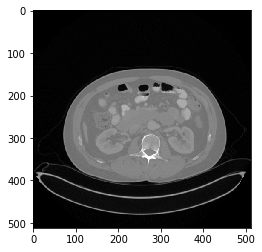

In [33]:

import matplotlib.pyplot as plt
plt.imshow(image[0][0].numpy(),cmap='gray')
#plt.savefig('origin{}.png'.format(k))

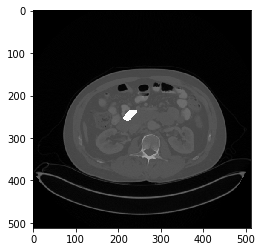

In [34]:
import matplotlib.pyplot as plt
plt.imshow(label[0][0].numpy()+image[0][0].numpy(),cmap='gray')
#plt.savefig('label{}.png'.format(k))

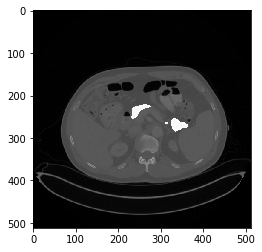

In [17]:
import matplotlib.pyplot as plt
plt.imshow(paddle.argmax(predict,axis=1)[0].numpy()+image[0][0].numpy(),cmap='gray')
#plt.savefig('pre{}.png'.format(k))

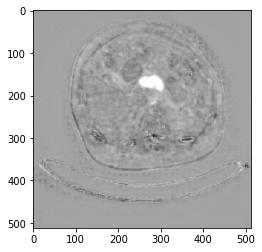

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(predict[0][1].numpy(),cmap='gray')

In [ ]:
paddle.argmax(predict,axis=1)[0].numpy().shape

(512, 512)

In [ ]:
import paddle
import paddle.nn as nn

cv2d = nn.Conv2D(1,1,1,1)
param = paddle.ones([1,1,50,50])
param = paddle.create_parameter(shape=param.shape, dtype=str(param.numpy().dtype), default_initializer=paddle.nn.initializer.Assign(param))

param.stop_gradient = True
cv2d.weight = param
print(cv2d.weight)

Parameter containing:
Tensor(shape=[1, 1, 50, 50], dtype=float32, place=CPUPlace, stop_gradient=True,
       [[[[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          ...,
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]]]])


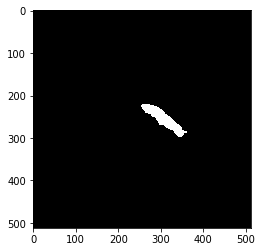

In [ ]:
count = 0
for data, label in test_loader:
    count += 1
    if count == 25:break

label = label.astype('float32')    
out = cv2d(label)
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(label[0][0].numpy(), cmap='gray')

In [ ]:
out[0][0].numpy().max()

25.0

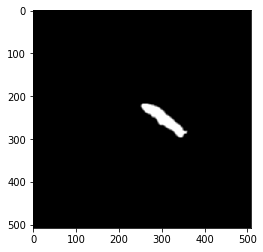

In [ ]:
plt.imshow(out[0][0].numpy(), cmap='gray')